In [1]:
import torch
from PIL import Image
import numpy
import sys
from torchvision import transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt

from vit_rollout import VITAttentionRollout
from vit_grad_rollout import VITAttentionGradRollout
from vit_flow import VITAttentionFlow
from vit_flow_inverse import VITAttentionFlowInverse

/Data/nlp_env/miniconda3/envs/venv_ea/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/Data/nlp_env/miniconda3/envs/venv_ea/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
img = Image.open("examples/input.png")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE}")

IMAGE_SIZE = 224
DISCARD_RATIO = 0.9

def preprocess_image(image_path, transform):
    img = Image.open(image_path)
    input_tensor = transform(img).unsqueeze(0)
    return input_tensor.to(DEVICE)

def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

model = torch.hub.load('facebookresearch/deit:main', 
        'deit_tiny_patch16_224', pretrained=True)
model.eval()
model.to(DEVICE)

Using cuda


Using cache found in /users/eleves-a/2018/nicolas.lopes/.cache/torch/hub/facebookresearch_deit_main
/Data/nlp_env/miniconda3/envs/venv_ea/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop2): Dropout(p=0.0, inplace=Fals

/Data/nlp_env/miniconda3/envs/venv_ea/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1706726118919/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Using attention_flow


100%|██████████| 197/197 [06:50<00:00,  2.08s/it]


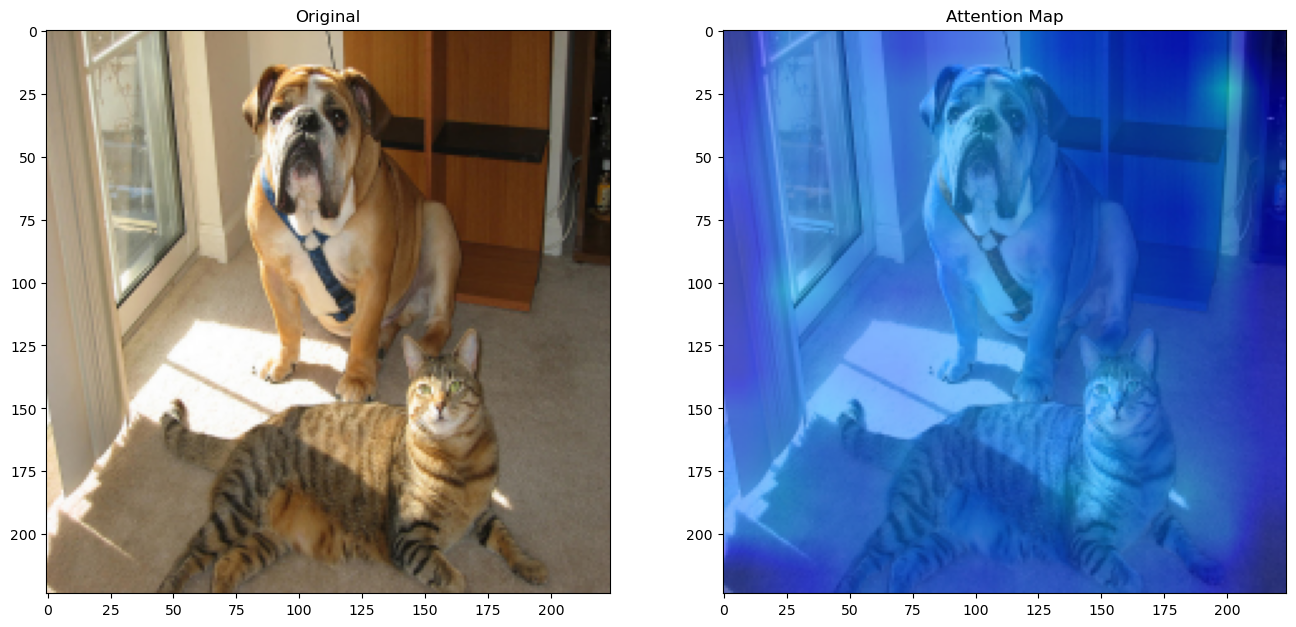

In [3]:
#@title Select the rollout strategy to be used and display results
#@markdown **Note** that for `grad_attention_rollout` passing a category index is mandatory.
rollout_strategy = "attention_flow" #@param ["attention_rollout", "grad_attention_rollout", "attention_flow"]
category_index =  264#@param {type:"integer"}

print(f"Using {rollout_strategy}")

input_tensor  = preprocess_image("examples/input.png", transform)

if rollout_strategy == "grad_attention_rollout" and category_index < 0:
    raise Exception("Category index is mandatory when using Gradient Attention Rollout")

elif rollout_strategy == "grad_attention_rollout" and category_index > 0:
    grad_rollout = VITAttentionGradRollout(model, discard_ratio=DISCARD_RATIO)
    mask = grad_rollout(input_tensor, category_index)
    name = "grad_rollout_{}_{:.3f}_{}.png".format(category_index,
        DISCARD_RATIO, "mean")

elif rollout_strategy == "attention_rollout":
    attention_rollout = VITAttentionRollout(model, discard_ratio=DISCARD_RATIO)
    mask = attention_rollout(input_tensor)
    name = "attention_rollout_{:.3f}_{}.png".format(DISCARD_RATIO, "mean")
    
elif rollout_strategy == "attention_flow":
    attention_flow = VITAttentionFlowInverse(model, discard_ratio=DISCARD_RATIO)
    mask = attention_flow(input_tensor)
    name = "attention_flow_{:.3f}_{}.png".format(DISCARD_RATIO, "mean")

np_img = np.array(img)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask = show_mask_on_image(np_img, mask)

# mask = (mask - mask.min()) / (mask.max() - mask.min())
# mask = mask.clip(0.7,1)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(img)
_ = ax2.imshow(mask)

In [ ]:
mask.min()

0